# Handwritten Letter or Digit Recognition Model using EMNIST

This notebook demonstrates how to build, train, and save a handwritten letter recognition model using the EMNIST dataset.

## Step 1: Import Required Libraries

In [1]:
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

## Step 2: Load the EMNIST Dataset

In [2]:
# Load EMNIST dataset
from emnist import extract_training_samples, extract_test_samples

# Use 'byclass' to include all 62 classes (digits, uppercase, and lowercase letters)
x_train, y_train = extract_training_samples('byclass')
x_test, y_test = extract_test_samples('byclass')

# Reshape and normalize the data
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1)).astype('float32') / 255
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1)).astype('float32') / 255

# Adjust labels to be zero-indexed (0 to 61)
y_train = y_train - 1
y_test = y_test - 1

# Ensure all labels are within the valid range (0 to 61)
y_train = np.clip(y_train, 0, 61)
y_test = np.clip(y_test, 0, 61)

# Convert labels to one-hot encoding
num_classes = 62  # EMNIST 'byclass' has 62 classes (0-9, A-Z, a-z)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

## Step 3: Data Augmentation

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,       # Randomly rotate images by up to 10 degrees
    width_shift_range=0.1,   # Randomly shift images horizontally by up to 10% of the width
    height_shift_range=0.1,  # Randomly shift images vertically by up to 10% of the height
    zoom_range=0.1,          # Randomly zoom in/out on images by up to 10%
    shear_range=0.1,         # Apply shear transformations (optional)
    horizontal_flip=False,   # Do not flip images horizontally (since letters are not symmetric)
    vertical_flip=False,     # Do not flip images vertically (since letters are not symmetric)
    fill_mode='nearest'      # Fill in missing pixels with the nearest value
)

datagen.fit(x_train)

## Step 4: Build the Model

In [4]:
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Define the model
model = models.Sequential([
    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten the output
    layers.Flatten(),

    # Fully connected layers
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Output layer
    layers.Dense(num_classes, activation='softmax')
])

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.1

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Add learning rate scheduler callback
lr_callback = LearningRateScheduler(lr_scheduler)

c:\Users\lzyah\OneDrive\Documents\GitHub\scan-ai\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Step 5: Train the Model

In [ ]:
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)
# history = model.fit(datagen.flow(x_train, y_train, batch_size=128),
#                     epochs=30,
#                     validation_data=(x_test, y_test),
#                     callbacks=[lr_callback])

Epoch 1/10
4363/4363 ━━━━━━━━━━━━━━━━━━━━ 403s 92ms/step - accuracy: 0.7344 - loss: 0.9138 - val_accuracy: 0.8541 - val_loss: 0.4062
Epoch 2/10
4363/4363 ━━━━━━━━━━━━━━━━━━━━ 391s 90ms/step - accuracy: 0.8374 - loss: 0.4649 - val_accuracy: 0.8608 - val_loss: 0.3796
Epoch 3/10
4363/4363 ━━━━━━━━━━━━━━━━━━━━ 387s 89ms/step - accuracy: 0.8464 - loss: 0.4316 - val_accuracy: 0.8662 - val_loss: 0.3669
Epoch 4/10
4363/4363 ━━━━━━━━━━━━━━━━━━━━ 387s 89ms/step - accuracy: 0.8495 - loss: 0.4179 - val_accuracy: 0.8652 - val_loss: 0.3671
Epoch 5/10
4363/4363 ━━━━━━━━━━━━━━━━━━━━ 386s 88ms/step - accuracy: 0.8535 - loss: 0.4052 - val_accuracy: 0.8675 - val_loss: 0.3569
Epoch 6/10
4363/4363 ━━━━━━━━━━━━━━━━━━━━ 388s 89ms/step - accuracy: 0.8549 - loss: 0.3985 - val_accuracy: 0.8665 - val_loss: 0.3559
Epoch 7/10
4363/4363 ━━━━━━━━━━━━━━━━━━━━ 390s 89ms/step - accuracy: 0.8577 - loss: 0.3918 - val_accuracy: 0.8671 - val_loss: 0.3547
Epoch 8/10
4363/4363 ━━━━━━━━━━━━━━━━━━━━ 399s 92ms/step - accuracy: 

c:\Users\lzyah\OneDrive\Documents\GitHub\scan-ai\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 190/5453 ━━━━━━━━━━━━━━━━━━━━ 9:08 104ms/step - accuracy: 0.8176 - loss: 0.5166

KeyboardInterrupt: 

## Step 6: Evaluate the Model

In [6]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')

3636/3636 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.8628 - loss: 0.3763
Test accuracy: 0.8627


## Step 7: Save the Model

In [7]:
# Save the model weights
model.save('handwritten_recognition_model.keras')
print("Model saved as 'handwritten_recognition_model.keras'")

Model saved as 'handwritten_recognition_model.keras'


## Step 8: Visualize Training Results

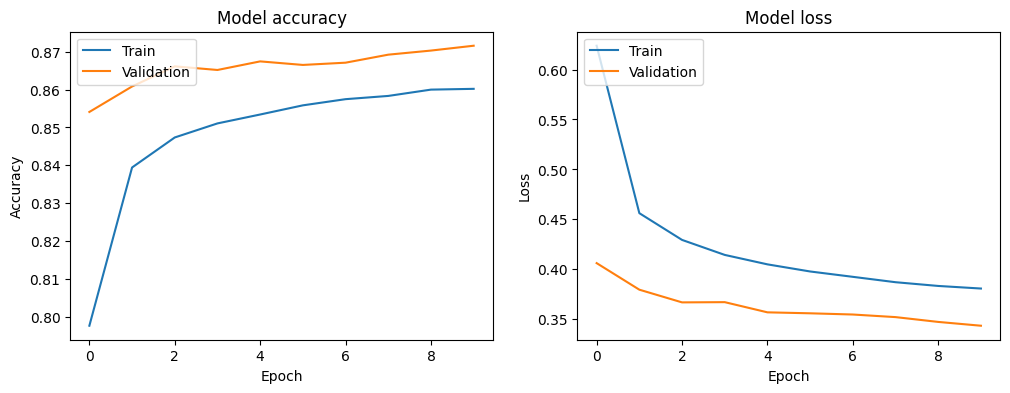

In [8]:
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

## Step 9: Predict and Visualize a Test Sample

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


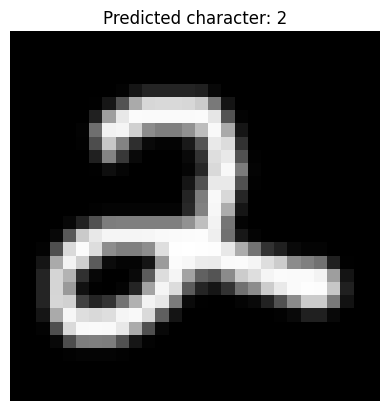

In [9]:
# Make a prediction on a test sample
sample = x_test[10].reshape(1, 28, 28, 1)  # Reshape for model input
prediction = model.predict(sample)  # Get model predictions
predicted_class = np.argmax(prediction) + 1  # Get the predicted class index

# Map the predicted class index to the corresponding character
# EMNIST 'byclass' mapping: 0-9 (digits), 10-35 (A-Z), 36-61 (a-z)
if predicted_class < 10:
    predicted_char = str(predicted_class)  # Digits 0-9
elif predicted_class < 36:
    predicted_char = chr(predicted_class + 55)  # Uppercase letters A-Z
else:
    predicted_char = chr(predicted_class + 61)  # Lowercase letters a-z

# Display the image
plt.imshow(x_test[10].reshape(28, 28), cmap='gray')
plt.title(f"Predicted character: {predicted_char}")
plt.axis('off')  # Hide the axes
plt.show()

## Step 10: Predict and Visualize a Custom Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


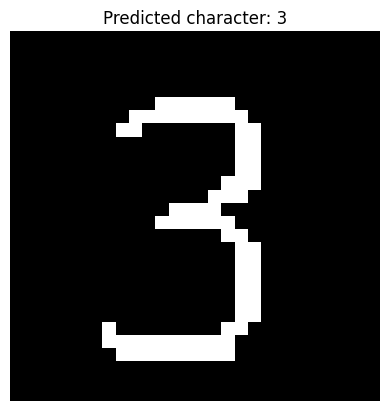

In [10]:
from tensorflow.keras.preprocessing import image
from PIL import Image, ImageOps

# Load the custom image
image_path = "images/3.png"  # Replace with the path to your image
img = Image.open(image_path).convert('L')  # Convert to grayscale

# Invert the colors to match EMNIST format
img = ImageOps.invert(img)

# Preprocess the image
img = img.resize((28, 28))  # Resize to 28x28
img_array = image.img_to_array(img)  # Convert to numpy array
img_array = img_array.reshape((28, 28))  # Reshape to (28, 28)
img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
img_array = img_array.reshape((1, 28, 28, 1))  # Reshape to (1, 28, 28, 1)

# Make a prediction
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction) + 1  # Get the predicted class index

# Map the predicted class index to the corresponding character
# EMNIST 'byclass' mapping: 0-9 (digits), 10-35 (A-Z), 36-61 (a-z)
if predicted_class < 10:
    predicted_char = str(predicted_class)  # Digits 0-9
elif predicted_class < 36:
    predicted_char = chr(predicted_class + 55)  # Uppercase letters A-Z
else:
    predicted_char = chr(predicted_class + 61)  # Lowercase letters a-z

# Display the image and prediction
plt.imshow(img_array.reshape(28, 28), cmap='gray')
plt.title(f"Predicted character: {predicted_char}")
plt.axis('off')
plt.show()